In [99]:
import mysql.connector as connector
import sklearn
import datetime 
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## SQL Connection & Import

In [100]:
conn = connector.connect(user='root', password='123456', host='localhost', port='3306', database='my_db')

mycursor = conn.cursor()

In [101]:
mycursor.execute('SELECT * FROM price_sentiment')
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Score', 'Positive' , 'Negative', 'Neutral', 'Total_Sentiment'])

df.set_index('Date', drop = True, inplace=True)
date = df.index
df.drop(['Open', 'High', 'Low', 'Dividends', 'Stock_Splits', 'Score', 'Positive',	'Negative',	'Neutral'], inplace=True, axis=1)

In [102]:
df

,Close,Volume,Total_Sentiment
Date,,,
2014-01-06,0.374438,409492000.0,0.00000
2014-04-23,0.452159,261580000.0,-1.00000
2015-06-01,0.541710,372660000.0,0.00000
2016-01-05,0.802491,490272000.0,1.00000
2016-09-28,1.642590,319788000.0,0.00000
...,...,...,...
2025-02-10,133.570000,216989000.0,5.84000
2025-02-11,132.800000,178356000.0,3.90909
2025-02-12,131.447000,49444900.0,4.76471


### Data Processing

In [103]:
df['Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)

df_date = df.index

In [104]:
df_columns = df.columns
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed)

df_transformed.columns = df_columns
df_transformed.set_index(df_date, inplace=True)


### Function train test split

In [105]:
def traintest(data):

    #X = data.drop(columns=['Close'], axis = 1)
    X= data.drop(['Close'],axis=1)
    Y = data['Close']
    
    X_train = X.iloc[0:int(0.7*len(X))]
    Y_train = Y.iloc[0:int(0.7*len(Y))]

    X_test = X.iloc[int(0.7*len(X)):len(X)]
    Y_test = Y.iloc[int(0.7*len(Y)):int(len(Y))]

    

    return X_train, X_test, Y_train,Y_test


## Linear Regression

In [106]:
X_train, X_test, Y_train,Y_test = traintest(df_transformed)

model=LinearRegression()

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [107]:
r2 = sklearn.metrics.r2_score(Y_test, y_pred)
print(r2)

mse = mean_squared_error(Y_test, y_pred)
print(mse)


-2.737574807457085
0.2755516786995839


In [108]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = model.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

17.865714969428456


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [109]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

In [110]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6],
    'model__fit_intercept': [True, False]
}

In [111]:
X = df.drop('Close', axis=1)

Y= df['Close']

In [112]:
# 🔹 Perform Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1  # Using R² as the metric
)

grid_search.fit(X, Y)  # Flatten Y to 1D array

print(f"Best Polynomial Degree: {grid_search.best_params_['poly__degree']}")
print(f"Best R² Score: {grid_search.best_score_:.4f}")

Best Polynomial Degree: 1
Best R² Score: -177.2255


## Decision Tree

In [113]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, Y_train,Y_test = traintest(df_transformed)

dt = DecisionTreeRegressor()

dt.fit(X_train, Y_train)

y_pred = dt.predict(X_test)

r2 = r2_score(Y_test, y_pred)

print(r2)

mse = mean_squared_error(Y_test, y_pred)
print(mse)

-2.639371917673276
0.26831169755483475


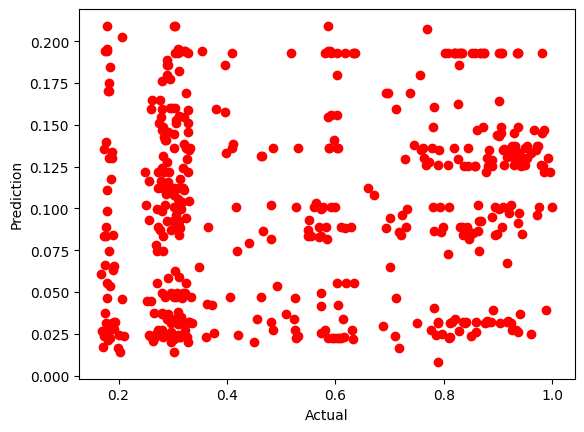

In [114]:
plt.scatter(Y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [115]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

19.2562


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [116]:
parameter ={
    'max_depth': [10,20,30,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':[1,2,4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=parameter, cv=5,n_jobs=-1,  scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
print(mse)

0.272672037366242


In [117]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

19.2562


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [118]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

18.961183333333334


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## Random Forest

In [119]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,Y_train)

rf_pred = rf.predict(X_test)

r2 = r2_score(Y_test,rf_pred)
print(r2)

mse = mean_squared_error(rf_pred, Y_test)
print(mse)

-2.7376532969221214
0.27555746531389


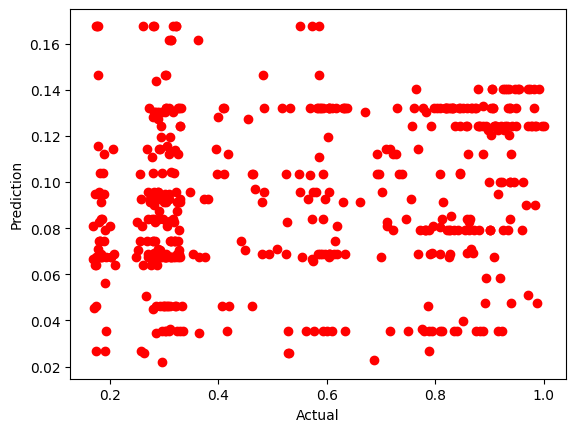

In [120]:
plt.scatter(Y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [121]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = rf.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

17.581835000000005


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [122]:
parameter ={
    'n_estimators':[100,200,300,400,500],
    'max_depth': [2,5,10,20,30, None],
    'min_samples_split':[2,5,10,20,30],
    'min_samples_leaf':[1,2,5,10,20,30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=parameter,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)


{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 100}


In [123]:
best_rf = grid_search.best_estimator_

rf_pred = best_rf.predict(X_test)

mse = mean_squared_error(rf_pred, Y_test)
print(mse)

0.27995215743993573


In [124]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_rf .predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

15.403385541858187


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [125]:
df_transformed.index = pd.to_datetime(df_transformed.index)

df_transformed.index = df_transformed.index.strftime('%d-%m-%Y')

## LSTM (TBC)

In [126]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [127]:
dnn = Sequential()
dnn.add(Dense(units=128, activation = 'relu', input_dim=2))
dnn.add(Dense(units=32, activation = 'relu'))
dnn.add(Dense(units=8, activation = 'relu'))
dnn.add(Dense(units=1, activation = 'linear'))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
dnn.compile(optimizer='adam', loss='mean_squared_error')

In [129]:
es = EarlyStopping(monitor='val_loss', mode = 'min',verbose=1, patience=200)

In [130]:
history = dnn.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - val_loss: 0.2747
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.2792
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.2827
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.2821
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.2821
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.2801
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.2803
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.2802
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.2832
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.2806
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.2773
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

In [139]:
prediction = dnn.predict(X_test) 
print(prediction)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[ 0.08555791]
 [ 0.08252351]
 [ 0.05793367]
 [ 0.07782389]
 [ 0.09276379]
 [ 0.06173766]
 [ 0.09285325]
 [ 0.07839711]
 [ 0.07637918]
 [ 0.07595335]
 [ 0.07430569]
 [ 0.08019608]
 [ 0.08628938]
 [ 0.07393535]
 [ 0.07703377]
 [ 0.09361823]
 [ 0.07383824]
 [ 0.0788538 ]
 [ 0.0735397 ]
 [ 0.09254999]
 [ 0.07158429]
 [ 0.07537274]
 [ 0.07300346]
 [ 0.09533738]
 [ 0.07868589]
 [ 0.08655511]
 [ 0.07086068]
 [ 0.07352453]
 [ 0.07733446]
 [ 0.07424979]
 [ 0.07780841]
 [ 0.07041235]
 [ 0.08777168]
 [ 0.08438793]
 [ 0.0776756 ]
 [ 0.07717644]
 [ 0.07226771]
 [ 0.0732135 ]
 [ 0.0687284 ]
 [ 0.08149233]
 [ 0.07256778]
 [ 0.07703143]
 [ 0.08455826]
 [ 0.08038857]
 [ 0.07792707]
 [ 0.07052997]
 [ 0.08224284]
 [ 0.07734033]
 [ 0.07596624]
 [ 0.08217484]
 [ 0.05925177]
 [ 0.07858531]
 [ 0.07226381]
 [ 0.05040584]
 [ 0.08877774]
 [ 0.08345462]
 [ 0.08381228]
 [ 0.07821375]
 [ 0.10308097]
 [ 0.08096583]
 [ 0.07695967]
 [ 0.07885504]
 [ 0.0854436 ]
 [ 0.07446679]


In [135]:
X_train, X_test, Y_train,Y_test = traintest(df_transformed)

In [140]:
len(Y_test)

478

In [141]:
len(prediction)

478

In [142]:
print(r2_score(Y_test,prediction))

-2.8887409652768268


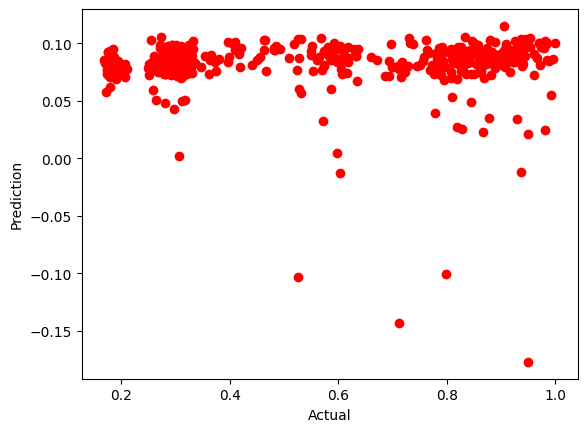

In [143]:
import matplotlib.pyplot as plt

plt.scatter(Y_test,prediction, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [145]:
conn.close()

mycursor.close()

True